# MPI validation
Comparison between MPI climate model and ORAS5

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
import warnings
import tqdm
import pathlib
import cmocean

# Import custom modules
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path("/Users/theo/research/enso2025_xro/data/mpi_Th/Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path("../data/XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_mpi = Th_mpi.sel(time=slice("1979", "2024"))
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T_34", "WWV": "h"})

## Diagnostics

### Seasonal synchronization

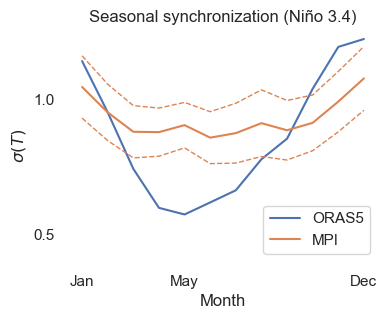

In [3]:
## func to compute std dev as a function of month
get_std = lambda x: x.groupby("time.month").std("time")

## compute std for each dataset
oras_std = get_std(Th_oras["T_34"])
mpi_std_mean = get_std(Th_mpi["T_34"]).mean("member")
mpi_std_std = get_std(Th_mpi["T_34"]).std("member")

## months (x-coordinate for plotting
months = np.arange(1, 13)

### Set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot for ORAS5
oras_plot = ax.plot(months, oras_std, label="ORAS5")

## plot MPI ensemble mean
mpi_plot = ax.plot(months, mpi_std_mean, label="MPI")

## plot ± bounds for MPI
kwargs = dict(c=mpi_plot[0].get_color(), ls="--", lw=1)
for s in [1, -1]:
    ax.plot(months, s * mpi_std_std + mpi_std_mean, **kwargs)

## adjust limits and label
ax.set_ylim([0.4, None])
ax.set_yticks([0.5, 1])
ax.set_xticks([1, 5, 12], labels=["Jan", "May", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel(f"$\\sigma(T)$")
ax.set_title("Seasonal synchronization (Niño 3.4)")
ax.legend()
plt.show()

### $T,h$ cross-correlation

Compute stats

In [4]:
## compute cross-correlation
xcorr_oras = xcorr(Th_oras, Th_oras["T_34"], maxlags=18)
xcorr_mpi = xcorr(Th_mpi, Th_mpi["T_34"], maxlags=18)

## compute upper/lower bounds for plotting
xcorr_mpi_ub = xcorr_mpi.mean("member") + xcorr_mpi.std("member")
xcorr_mpi_lb = xcorr_mpi.mean("member") - xcorr_mpi.std("member")

Make plot

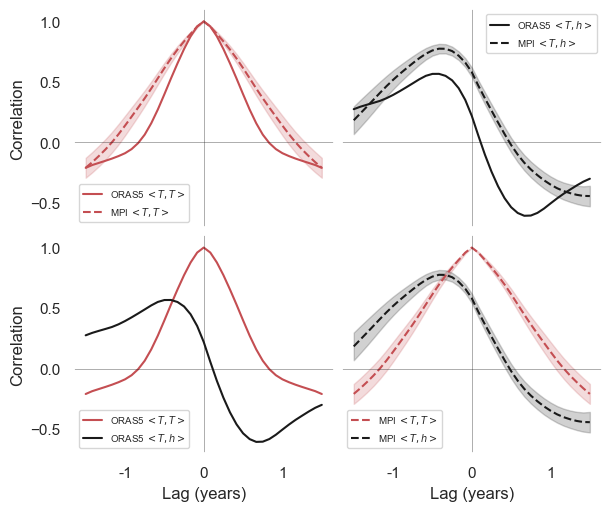

In [5]:
def format_axs(axs):
    ## add axis lines to plots
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    for ax in axs.flatten():
        ax.axhline(0, **axis_kwargs)
        ax.axvline(0, **axis_kwargs)
        ax.set_ylim([-0.7, 1.1])

    #### label plots

    ## bottom row
    for ax in axs[1]:
        ax.set_xlabel("Lag (years)")
        ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])

    ## top row
    for ax in axs[0]:
        ax.set_xticks([])

    ## left col
    for ax in axs[:, 0]:
        ax.set_ylabel("Correlation")

    ## right col
    for ax in axs[:, 1]:
        ax.set_yticks([])

    return axs


## specify plot properties for legend
legend_prop = dict(size=7)

fig, axs = plt.subplots(2, 2, figsize=(6, 5), layout="constrained")

## plot <T,T>

axs[0, 0].plot(xcorr_oras.lag, xcorr_oras["T_34"], c="r", label="ORAS5 $<T, T>$")
axs[0, 0].plot(
    xcorr_mpi.lag,
    xcorr_mpi["T_34"].mean("member"),
    c="r",
    ls="--",
    label="MPI $<T, T>$",
)
axs[0, 0].fill_between(
    xcorr_mpi.lag, xcorr_mpi_ub["T_34"], xcorr_mpi_lb["T_34"], color="r", alpha=0.2
)
axs[0, 0].legend(prop=legend_prop)

## plot <T,h>
axs[0, 1].plot(xcorr_oras.lag, xcorr_oras["h"], c="k", label="ORAS5 $<T, h>$")
axs[0, 1].plot(
    xcorr_mpi.lag, xcorr_mpi["h"].mean("member"), c="k", ls="--", label="MPI $<T, h>$"
)
axs[0, 1].fill_between(
    xcorr_mpi.lag, xcorr_mpi_ub["h"], xcorr_mpi_lb["h"], color="k", alpha=0.2
)
axs[0, 1].legend(prop=legend_prop)

## Plot both for ORAS5
axs[1, 0].plot(xcorr_oras.lag, xcorr_oras["T_34"], c="r", label="ORAS5 $<T, T>$")
axs[1, 0].plot(xcorr_oras.lag, xcorr_oras["h"], c="k", label="ORAS5 $<T, h>$")
axs[1, 0].legend(prop=legend_prop)

## Plot both for MPI
axs[1, 1].plot(
    xcorr_mpi.lag,
    xcorr_mpi["T_34"].mean("member"),
    c="r",
    ls="--",
    label="MPI $<T, T>$",
)
axs[1, 1].fill_between(
    xcorr_mpi.lag, xcorr_mpi_ub["T_34"], xcorr_mpi_lb["T_34"], color="r", alpha=0.2
)
axs[1, 1].plot(
    xcorr_mpi.lag, xcorr_mpi["h"].mean("member"), c="k", ls="--", label="MPI $<T, h>$"
)
axs[1, 1].fill_between(
    xcorr_mpi.lag, xcorr_mpi_ub["h"], xcorr_mpi_lb["h"], color="k", alpha=0.2
)
axs[1, 1].legend(prop=legend_prop)

axs = format_axs(axs)

plt.show()